In [12]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import itertools
import torch.optim as optim
import numpy as np
import csv

In [13]:
def rotation_matrix(n, theta):
    """
    Compute the Rodrigues rotation matrix for a given axis n and angle theta.

    Parameters:
        n (ndarray): rotaion axis (normalized).
        theta (float): rotation angle in radian.

    Returns:
        - (ndarray) -- 3x3 rotation matrix.
    """
    K = np.array([[0.0, -n[2], n[1]], [n[2], 0.0, -n[0]], [-n[1], n[0], 0.0]])
    I = np.eye(3)
    R = I + np.sin(theta) * K + (1.0 - np.cos(theta)) * np.dot(K, K)
    return R


def create_shift_tensor(ks, Rs):
    """
    Create shift tensors for all sites.

    Args:
        ks (list): components of K, (Kxx, Kyy, Kzz, Kyz, Kzx, Kxy).
        Rs (list): symmetry operations for each site.

    Returns:
        - (list) -- shift tensors in each site.
    """
    k1, k2, k3, k4, k5, k6 = ks
    K = [[k1,k6,k5],[k6,k2,k4],[k5,k4,k3]]
    Ks = [R @ K @ R.T for R in Rs]
    return Ks


def nmr_shift(Ks, h):
    """
    Compute the NMR shift without the contributions from the quadrupolar interactions.

    Args:
        Ks (list): list of 3x3 shift tensors.
        h (ndarray): magnetic field.

    Returns:
        - (list) -- NMR shift for each K.
    """
    shift = [np.diag(h @ K @ h.T) for K in Ks]
    return shift


def compute_shift(n, s, ks, Rs):
    """
    Compute angle dependence of NMR shift.

    Args:
        n (list): rotation axis.
        s (list): starting vector.
        ks (list): components of K, (Kxx, Kyy, Kzz, Kyz, Kzx, Kxy).
        Rs (list): symmetry operations for each site.

    Returns:
        - (ndarray) -- angles.
        - (list) -- angle dependence of NMR shift around n axis.
        - (list) -- angle dependence of NMR shift around nxs axis.
    """
    theta = np.radians(range(91))

    n = np.array(n)
    n1 = n / np.linalg.norm(n)
    s = np.array(s)
    s = s / np.linalg.norm(s)
    n2 = np.cross(n1, s)
    h1 = np.array([rotation_matrix(n1, t) @ s for t in theta])
    h2 = np.array([rotation_matrix(n2, t) @ s for t in theta])

    Ks = create_shift_tensor(ks, Rs)

    shift1 = nmr_shift(Ks, h1)
    shift2 = nmr_shift(Ks, h2)

    return theta, shift1, shift2


def plot_data(theta, shift1, shift2):
    """
    Plot angle dependences.

    Args:
        theta (ndarray): angles.
        shift1 (list): angle dependence of NMR shift around n axis.
        shift2 (list): angle dependence of NMR shift around nxs axis.
    """
    fig, axes = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
    axes.set_title("Knight shift of Te")
    axes.set_xlabel("Rotation angle [deg.]", fontsize=15)
    axes.set_ylabel(r"Knight shift [$\times {10}^4$]", fontsize=15)

    axes.set_xlim([0, 90])
    axes.grid()

    n_site = len(shift1)
    colors = ["blue", "green", "red", "orange"]
    theta = theta * 180/np.pi
    for site in range(n_site):
        axes.plot(theta, shift1[site]*10000, "-", color=colors[site], label=f'$K_{site+1}$')
    for site in range(n_site):
        axes.plot(theta, shift2[site]*10000, "--", color=colors[site], label=f'$K_{site+1}$')
    axes.legend()

    plt.autoscale(enable=True, axis='y')
    plt.show()

def output_shift_values(theta, shift1, shift2):
    """
    Output angle and shift values in the specified format.
    """
    for j in range(3):
        print(f"Angle,Shift1[{j+1}] value")  # jの値を表示する
        for i in range(0, 91):
            print(f"{i},{shift1[j][i]*10000}")
    for j in range(3):
        print(f"Angle,Shift2[{j+1}] value")  # jの値を表示する
        for i in range(0, 91):
            print(f"{i},{shift2[j][i]*10000}")

In [14]:
def generate_vectors():
    # t1, p1 をランダム生成
    t1 = np.random.uniform(0, 180)  # 0° <= t1 <= 180°
    p1 = np.random.uniform(-180, 180)  # -180° <= p1 <= 180°

    # ベクトル n を計算
    nx = np.cos(np.radians(p1)) * np.sin(np.radians(t1))
    ny = np.sin(np.radians(p1)) * np.sin(np.radians(t1))
    nz = np.cos(np.radians(t1))
    n = np.array([nx, ny, nz])

    while True:
        # ランダムなベクトルを生成
        random_vec = np.random.randn(3)
        # 直交条件を満たすように調整
        s = random_vec - np.dot(random_vec, n) * n
        if np.linalg.norm(s) > 1e-6:  # 0ベクトルでない場合にのみ採用
            s = s / np.linalg.norm(s)  # s を正規化
            # t2, p2 を逆算
            t2 = np.degrees(np.arccos(s[2]))
            p2 = np.degrees(np.arctan2(s[1], s[0]))
            if p2 < 0:
                p2 += 360  # p2 を 0°〜360° に変換

            # p2 が 120° 以下であれば終了
            # if p2 <= 120:
                break

    return t1, p1, t2, p2, n, s

# ランダム生成と内積の確認
t1, p1, t2, p2, n, s = generate_vectors()
dot_product = np.dot(n, s)

print(f"t1: {t1}, p1: {p1}")
print(f"t2: {t2}, p2: {p2}")
print(f"n: {n}")
print(f"s: {s}")
print(f"内積 (n・s): {dot_product}")

t1: 57.56132618951691, p1: -33.926593748944754
t2: 95.38208799427484, p2: 239.50623146494286
n: [ 0.70028364 -0.47104303  0.53639658]
s: [-0.5052075  -0.85788548 -0.09379707]
内積 (n・s): -7.297764545558478e-18


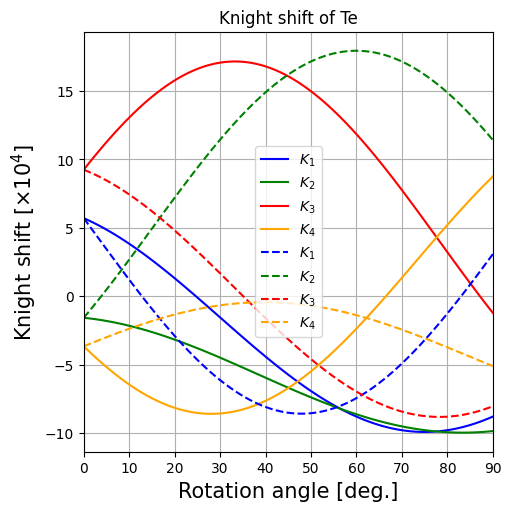

Angle,Shift1[1] value
0,5.711433828849462
1,5.560716071851416
2,5.401346378814363
3,5.233518917160263
4,5.057438158799296
5,4.873318631012363
6,4.681384655082636
7,4.481870072994625
8,4.27501796253373
9,4.061080341133432
10,3.8403178588308338
11,3.6129994807047807
12,3.379402159183293
13,3.1398104966197424
14,2.8945163985486975
15,2.6438187180440007
16,2.3880228916123234
17,2.127440567065847
18,1.8623892238274065
19,1.593191786130701
20,1.3201762295868869
21,1.0436751815967806
22,0.7640255160956443
23,0.48156794312415596
24,0.19664659372573431
25,-0.09039139932415538
26,-0.3791963244457908
27,-0.6694163173248989
28,-0.9606977896051182
29,-1.2526858596809538
30,-1.5450247850663221
31,-1.8373583958120066
32,-2.1293305284438553
33,-2.420585459893112
34,-2.710768340890192
35,-2.999525628293848
36,-3.286505515829022
37,-3.571358362708618
38,-3.853737119616934
39,-4.133297751535789
40,-4.4096996568982
41,-4.68260608255894
42,-4.951684534076349
43,-5.216607180805607
44,-5.477051255309885
45,-

In [15]:
# In the case of Te. (Te1 is on y-bond).
ks = [-0.08e-2, 0.13e-2, -0.05e-2, -0.11e-2, 0.0, 0.0]

E = np.eye(3)
C4 = rotation_matrix([0,0,1], np.pi/2) # for V2.
C2 = rotation_matrix([0,0,1], np.pi) # for V3.
C4i = C4.T # for V4.

Rs = [E, C4, C2, C4i]

theta, shift1, shift2 = compute_shift(n, s, ks, Rs)
plot_data(theta, shift1, shift2)

# 指定フォーマットで出力
output_shift_values(theta, shift1, shift2)

In [16]:

def save_to_csv(filename, angles, shifts, index):
    """
    Save the angles and shifts to a CSV file.

    Args:
        filename (str): Output CSV file name.
        angles (ndarray): Array of angles.
        shifts (list): Shift values for one site.
        index (int): Site index (1-based).
    """
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Header
        writer.writerow(["x", "y"])
        # Data
        for angle, shift in zip(angles, shifts):
            writer.writerow([angle, shift])

def output_shift_to_csv(theta, shift1, shift2):
    """
    Output angle and shift values to CSV files.

    Args:
        theta (ndarray): Array of angles.
        shift1 (list): Shift values for each site around n axis.
        shift2 (list): Shift values for each site around nxs axis.
    """
    # Convert angles to degrees
    angles = np.round(theta * 180 / np.pi).astype(int)  # 四捨五入で整数化
    
    # Save Shift1 data
    for i, shifts in enumerate(shift1, start=1):
        filename = f"sample({i}).csv"
        save_to_csv(filename, angles, shifts*10000, i)
    
    # Save Shift2 data
    for i, shifts in enumerate(shift2, start=1):
        filename = f"sample{i}.csv"
        save_to_csv(filename, angles, shifts*10000, i)

# 実行例
output_shift_to_csv(theta, shift1, shift2)

In [17]:
# 回転行列(PyTorch版)
def rotation_matrix(n, theta):
    """
    Compute the Rodrigues rotation matrix for a given axis n and angle theta.

    Parameters:
        n (torch.Tensor): Rotation axis (normalized).
        theta (float): Rotation angle in radian.

    Returns:
        - (torch.Tensor) -- 3x3 rotation matrix.
    """
    K = torch.tensor([[0.0, -n[2], n[1]], 
                      [n[2], 0.0, -n[0]], 
                      [-n[1], n[0], 0.0]])
    I = torch.eye(3)
    R = I + torch.sin(theta) * K + (1.0 - torch.cos(theta)) * torch.mm(K, K)
    return R

# 外積(PyTorch版)
def cross_product(v1, v2):
    return torch.cross(v1, v2, dim=0)

# 磁場ベクトル(PyTorch版)
def magnetic(axis, vec, theta):
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    
    axis = axis.unsqueeze(0)  # (1, 3)
    vec = vec.unsqueeze(0)    # (1, 3)
    
    rotated_vecs = []
    for i in range(theta.size(0)):
        theta_i = theta[i]
        cos_theta_i = cos_theta[i]
        sin_theta_i = sin_theta[i]
        
        axis_i = axis[0]
        vec_i = vec[0]
        
        rotated_vec = vec_i * cos_theta_i + cross_product(axis_i, vec_i) * sin_theta_i + axis_i * (torch.matmul(axis_i.unsqueeze(1).T, vec_i.unsqueeze(1)).squeeze() * (1 - cos_theta_i))
        rotated_vecs.append(rotated_vec)
    
    return torch.stack(rotated_vecs)

# モデル関数(PyTorch版)
def model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    rad = torch.pi / 180.0  # Conversion factor from degrees to radians
    nx = torch.cos(p1 * rad) * torch.sin(t1 * rad)
    ny = torch.sin(p1 * rad) * torch.sin(t1 * rad)
    nz = torch.cos(t1 * rad)
    sx = torch.cos(p2 * rad) * torch.sin(t2 * rad)
    sy = torch.sin(p2 * rad) * torch.sin(t2 * rad)
    sz = torch.cos(t2 * rad)
    theta = x * rad

    # Define matrices
    E = torch.eye(3)
    C4 = rotation_matrix(torch.tensor([0.0, 0.0, 1.0]), torch.tensor([torch.pi / 2.0])) # for V2.
    C2 = rotation_matrix(torch.tensor([0.0, 0.0, 1.0]), torch.tensor([torch.pi])) # for V3.
    C4i = C4.T # for V4.

    Rs = [E, C4, C2, C4i]
    
    h = magnetic(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz]), theta)
    ht = magnetic((cross_product(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz]))), torch.stack([sx, sy, sz]), theta)
    k = torch.stack([
    torch.stack([k1, k6, k5]),
    torch.stack([k6, k2, k4]),
    torch.stack([k5, k4, k3])
    ])
    Ks = [torch.einsum('ik,kl,jl->ij', R, k, R) for R in Rs]
    shift1 = [torch.einsum('ij,jk,ik->i', h, K, h) for K in Ks]
    shift2 = [torch.einsum('ij,jk,ik->i', ht, K, ht) for K in Ks]
    return {'shift1': torch.stack(shift1), 'shift2': torch.stack(shift2)}

In [18]:
# 各CSVファイルの読み込み
csv_files1 = ['sample(1).csv', 'sample(2).csv', 'sample(3).csv', 'sample(4).csv']
df1 = [pd.read_csv(f) for f in csv_files1]

csv_files2 = ['sample1.csv', 'sample2.csv', 'sample3.csv', 'sample4.csv']
df2 = [pd.read_csv(f) for f in csv_files2]

dfs = [df1, df2]

# データの抽出
x_values = []
y_values = []

for df_group in dfs:
    for i in range(len(df_group)):
        x_values.append(df_group[i]['x'].values)
        y_values.append(df_group[i]['y'].values)

# リストの全てのデータをtorch.tensorに変換
x_tensors = []
y_tensors = []

for x, y in zip(x_values, y_values):
    x_tensors.append(torch.tensor(x, dtype=torch.float32, requires_grad=True))
    y_tensors.append(torch.tensor(y, dtype=torch.float32))

# 結果を個別に代入（必要なら）
x1, x2, x3, x4, x5, x6, x7, x8 = x_tensors
y1, y2, y3, y4, y5, y6, y7, y8 = y_tensors

In [19]:
# 損失関数の定義
def loss_fn(y_p, y):
    squared_diffs = (y_p - y)**2
    return torch.sqrt(squared_diffs.mean())

In [20]:
# 損失関数の和
def combined_loss_fn(*args):
    total_loss = 0
    # y_predとy_actualをペアでループしながらlossを計算
    for y_pred, y_actual in zip(args[::2], args[1::2]):
        total_loss += loss_fn(y_pred, y_actual)
    
    return total_loss

In [21]:
# 全ての順列を生成
permutations = list(itertools.permutations([0, 1, 2, 3]))

# 最適化のためのobjective関数
def objective(trial, perm):
    # Optunaでパラメータをサンプリング
    k1 = torch.tensor(trial.suggest_float('k1', -15, 15), dtype=torch.float32, requires_grad=True)
    k2 = torch.tensor(trial.suggest_float('k2', -15, 15), dtype=torch.float32, requires_grad=True)
    k3 = torch.tensor(trial.suggest_float('k3', -15, 15), dtype=torch.float32, requires_grad=True)
    k4 = torch.tensor(trial.suggest_float('k4', -15, 15), dtype=torch.float32, requires_grad=True)
    k5 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
    k6 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
    t1 = torch.tensor(trial.suggest_float('t1', 0.0, 180.0), dtype=torch.float32, requires_grad=True)
    p1 = torch.tensor(trial.suggest_float('p1', -180.0, 180.0), dtype=torch.float32, requires_grad=True)
    t2 = torch.tensor(trial.suggest_float('t2', 0.0, 180.0), dtype=torch.float32, requires_grad=True)
    p2 = torch.tensor(trial.suggest_float('p2', -180.0, 180.0), dtype=torch.float32, requires_grad=True)

    # モデルにこれらのパラメータを使用
    outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6, x7, x8]]
    
    # 順列に基づいた出力の取得
    y_p1, y_p2, y_p3, y_p4 = [outputs[i]['shift1'][perm[i]] for i in range(4)]
    y_p5, y_p6, y_p7, y_p8 = [outputs[i+4]['shift2'][perm[i]] for i in range(4)]

    # 損失関数の計算
    loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6, y_p7, y7, y_p8, y8)

    return loss.item()

# 最適化ループ
max_global_iterations = 1  # グローバルな最大繰り返し回数
global_iteration = 0

# グローバルな最良結果を保存するための変数
global_best_loss = float('inf')
global_best_params = None
global_best_combination = None

# 損失関数が0.01以下になるまで以下の計算を繰り返す
while global_best_loss > 1e-2 and global_iteration < max_global_iterations:
    print(f"\nGlobal iteration {global_iteration + 1}")

    # 6通りの組み合わせごとにエポック計算を行うためのループ
    for perm in permutations:
        print(f"Evaluating combination: perm1={perm}, perm2={perm}")

        # 最適化のための変数初期化
        best_epoch0_loss = float('inf')
        best_params = None

        # Optunaを使用してパラメータを最適化
        for _ in range(3):
            # Optunaで最適化
            study = optuna.create_study(direction='minimize')
            study.optimize(lambda trial: objective(trial, perm), n_trials=100)

            # epoch0のLossが最小のパラメータを保持
            if study.best_value < best_epoch0_loss:
                best_epoch0_loss = study.best_value
                best_params = study.best_params

        # エポック計算 (各組み合わせごとに計算)
        if best_params is not None:
            print(f"Starting training for combination: perm1={perm}, perm2={perm}")

            # 最適化されたパラメータで初期化
            k1 = torch.nn.Parameter(torch.tensor(best_params['k1'], dtype=torch.float32))
            k2 = torch.nn.Parameter(torch.tensor(best_params['k2'], dtype=torch.float32))
            k3 = torch.nn.Parameter(torch.tensor(best_params['k3'], dtype=torch.float32))
            k4 = torch.nn.Parameter(torch.tensor(best_params['k4'], dtype=torch.float32))
            k5 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
            k6 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
            t1 = torch.nn.Parameter(torch.tensor(best_params['t1'], dtype=torch.float32))
            p1 = torch.nn.Parameter(torch.tensor(best_params['p1'], dtype=torch.float32))
            t2 = torch.nn.Parameter(torch.tensor(best_params['t2'], dtype=torch.float32))
            p2 = torch.nn.Parameter(torch.tensor(best_params['p2'], dtype=torch.float32))
            
            # 既存のパラメータに新しい初期値を設定
            k1.data = torch.tensor(best_params['k1'], dtype=torch.float32)
            k2.data = torch.tensor(best_params['k2'], dtype=torch.float32)
            k3.data = torch.tensor(best_params['k3'], dtype=torch.float32)
            k4.data = torch.tensor(best_params['k4'], dtype=torch.float32)
            k5 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
            k6 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
            t1.data = torch.tensor(best_params['t1'], dtype=torch.float32)
            p1.data = torch.tensor(best_params['p1'], dtype=torch.float32)
            t2.data = torch.tensor(best_params['t2'], dtype=torch.float32)
            p2.data = torch.tensor(best_params['p2'], dtype=torch.float32)

            optimizer = optim.Adam([k1, k2, k3, k4, t1, p1, t2, p2], lr=1e-1)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
            prev_loss = float('inf')

            # エポックごとのトレーニング
            best_params_during_epoch = None  # エポックごとの最良パラメータ
            best_epoch_loss = float('inf')  # 最良のロスを記録

            # Early Stopping を導入
            early_stopping_patience = 1000
            no_improvement_counter = 0

            # エポックごとのトレーニング
            for epoch in range(300000):
                optimizer.zero_grad()

                outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6, x7, x8]]

                y_p1, y_p2, y_p3, y_p4 = [outputs[i]['shift1'][perm[i]] for i in range(4)]
                y_p5, y_p6, y_p7, y_p8 = [outputs[i+4]['shift2'][perm[i]] for i in range(4)]

                loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6, y_p7, y7, y_p8, y8)

                if epoch == 0:
                    epoch0_loss = loss.item()
                    if epoch0_loss >= 35:
                        print(f"Epoch 0 Loss is {epoch0_loss}, which is >= 35. Stopping training.")
                        break
                
                # 最良のロスを持つ場合はパラメータを保存
                if loss.item() < best_epoch_loss:
                    best_epoch_loss = loss.item()
                    best_params_during_epoch = {
                        'k1': k1.item(),
                        'k2': k2.item(),
                        'k3': k3.item(),
                        'k4': k4.item(),
                        'k5': k5.item(),
                        'k6': k6.item(),
                        't1': t1.item(),
                        'p1': p1.item(),
                        't2': t2.item(),
                        'p2': p2.item()
                    }

                if loss.item() > prev_loss:
                    print(f"Loss increased at epoch {epoch}. Stopping training.")
                    break

                prev_loss = loss.item()
                loss.backward()

                optimizer.step()

                # 学習率の更新
                scheduler.step()

                if loss.item() < best_epoch_loss:
                    best_epoch_loss = loss.item()
                    best_params_during_epoch = {...}  # 保存処理
                    no_improvement_counter = 0  # リセット
                else:
                    no_improvement_counter += 1

                if no_improvement_counter >= early_stopping_patience:
                    print(f"Stopping early at epoch {epoch} due to no improvement.")
                    break

                with torch.no_grad():
                    for param in [k1, k2, k3]:
                        param.data = torch.clamp(param.data, -15, 15)
                    for param in [k4]:
                        param.data = torch.clamp(param.data, -15, 15)
                    for param in [t1, t2]:
                        param.data = torch.clamp(param.data, 0.0, 180.0)
                    for param in [p1]:
                        param.data = torch.clamp(param.data, -180.0, 180.0)
                    for param in [p2]:
                        param.data = torch.clamp(param.data, -180.0, 180.0)

                if epoch % 100 == 0:
                    # 勾配を確認（必要に応じて）
                    # for name, param in zip(['k1', 'k2', 'k3', 'k4', 't1', 'p1', 't2', 'p2'], [k1, k2, k3, k4, t1, p1, t2, p2]):
                    #     print(f"{name} grad: {param.grad}")
                    print(f'Epoch {epoch}, Loss: {loss.item()}, LR: {scheduler.get_last_lr()}')
                    # パラメータを表示する
                    print(f'Parameters: k1={k1.item()}, k2={k2.item()}, k3={k3.item()}, k4={k4.item()}, k5={k5.item()}, k6={k6.item()}, t1={t1.item()}, p1={p1.item()}, t2={t2.item()}, p2={p2.item()}')

            # 最良のパラメータを表示
            if best_params_during_epoch is not None:
                print(f"Best params during epoch training: {best_params_during_epoch}")
                # 最良のパラメータをTensorに変換して使用
                k1, k2, k3, k4, k5, k6, t1, p1, t2, p2 = [torch.tensor(best_params_during_epoch[param], dtype=torch.float32) for param in ['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 't1', 'p1', 't2', 'p2']]
            else:
                print("No improvement in loss during epoch training.")

            # 現在の組み合わせの最小Lossをグローバルな最小Lossと比較
            if prev_loss < global_best_loss:
                global_best_loss = prev_loss
                global_best_params = best_params_during_epoch
                global_best_combination = (perm, perm)

            print(f"Finished training for combination: perm1={perm}, perm2={perm}")


    print(f"Global best Loss after iteration {global_iteration + 1}: {global_best_loss}")
    global_iteration += 1

print(f"\nOptimization completed.")
print(f"Global best Loss: {global_best_loss}")
print(f"Global best params: {global_best_params}")
print(f"Global best combination: {global_best_combination}")

[I 2025-01-14 20:36:50,582] A new study created in memory with name: no-name-54f1b233-e7a2-4e17-bd90-5196cbc0c182



Global iteration 1
Evaluating combination: perm1=(0, 1, 2, 3), perm2=(0, 1, 2, 3)


[I 2025-01-14 20:36:50,727] Trial 0 finished with value: 88.10604095458984 and parameters: {'k1': 5.464125862714685, 'k2': 10.494266927054774, 'k3': 8.003445283244837, 'k4': -1.6470155787366192, 't1': 96.71183454003504, 'p1': -63.484911226714274, 't2': 99.79424701997928, 'p2': -16.840792917555575}. Best is trial 0 with value: 88.10604095458984.
[I 2025-01-14 20:36:50,795] Trial 1 finished with value: 98.51836395263672 and parameters: {'k1': 12.88930794481509, 'k2': -1.5734060823470113, 'k3': 10.44868088779976, 'k4': 4.5811067733606805, 't1': 164.1603655946067, 'p1': -161.81019740150188, 't2': 21.777996079024962, 'p2': 129.92772477026864}. Best is trial 0 with value: 88.10604095458984.
[I 2025-01-14 20:36:50,860] Trial 2 finished with value: 68.79246520996094 and parameters: {'k1': 0.809592695391073, 'k2': 9.982463638476691, 'k3': -3.7980159284930934, 'k4': 5.494492309620206, 't1': 33.00878903940975, 'p1': -60.86320914599524, 't2': 15.20593519052715, 'p2': 34.11093711167106}. Best is tr

Starting training for combination: perm1=(0, 1, 2, 3), perm2=(0, 1, 2, 3)
Epoch 0 Loss is 46.54093551635742, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 1, 2, 3), perm2=(0, 1, 2, 3)
Evaluating combination: perm1=(0, 1, 3, 2), perm2=(0, 1, 3, 2)


[I 2025-01-14 20:37:18,493] Trial 1 finished with value: 78.85808563232422 and parameters: {'k1': 3.4745948615021014, 'k2': 12.76373384052103, 'k3': -8.395313561786434, 'k4': 11.388217330710255, 't1': 97.73588486842061, 'p1': -133.74863598995472, 't2': 50.39582993704834, 'p2': -0.2849350126859349}. Best is trial 1 with value: 78.85808563232422.
[I 2025-01-14 20:37:18,566] Trial 2 finished with value: 79.936767578125 and parameters: {'k1': -12.30709686561135, 'k2': 3.8617163820824345, 'k3': 9.938220466402854, 'k4': -2.2618687611443082, 't1': 126.53648972228142, 'p1': 112.46466908212409, 't2': 123.90840111559795, 'p2': -124.2185287672254}. Best is trial 1 with value: 78.85808563232422.
[I 2025-01-14 20:37:18,706] Trial 3 finished with value: 102.48226165771484 and parameters: {'k1': 5.968968142567178, 'k2': -8.727345425503133, 'k3': -14.959194840893554, 'k4': 10.41851698631022, 't1': 27.738675489011428, 'p1': -100.7634131443248, 't2': 129.42023406653414, 'p2': -141.42776511592047}. Best 

Starting training for combination: perm1=(0, 1, 3, 2), perm2=(0, 1, 3, 2)
Epoch 0 Loss is 41.08564376831055, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 1, 3, 2), perm2=(0, 1, 3, 2)
Evaluating combination: perm1=(0, 2, 1, 3), perm2=(0, 2, 1, 3)


[I 2025-01-14 20:37:45,192] Trial 1 finished with value: 105.5027847290039 and parameters: {'k1': 13.442798043660957, 'k2': 7.4238563245207665, 'k3': 13.025562303840697, 'k4': -8.852290551236011, 't1': 6.191883431035416, 'p1': 37.66542483795621, 't2': 126.59809724094123, 'p2': 92.02203555195666}. Best is trial 0 with value: 101.99751281738281.
[I 2025-01-14 20:37:45,261] Trial 2 finished with value: 87.70001220703125 and parameters: {'k1': -8.51244939605226, 'k2': -8.30894381440561, 'k3': 14.365603531809946, 'k4': 13.641217093268956, 't1': 29.211223679296047, 'p1': -16.008636984320248, 't2': 159.42687051360153, 'p2': -58.01025130644156}. Best is trial 2 with value: 87.70001220703125.
[I 2025-01-14 20:37:45,394] Trial 3 finished with value: 77.7997817993164 and parameters: {'k1': 14.853331234540835, 'k2': -5.288630571758482, 'k3': -1.9897025010385612, 'k4': -13.372867060472494, 't1': 113.0872887372924, 'p1': 155.99265596472128, 't2': 23.1568805404721, 'p2': 44.84496062335785}. Best is t

Starting training for combination: perm1=(0, 2, 1, 3), perm2=(0, 2, 1, 3)
Epoch 0 Loss is 38.62007522583008, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 2, 1, 3), perm2=(0, 2, 1, 3)
Evaluating combination: perm1=(0, 2, 3, 1), perm2=(0, 2, 3, 1)


[I 2025-01-14 20:38:11,618] Trial 1 finished with value: 71.19912719726562 and parameters: {'k1': -7.379904226080997, 'k2': 4.535333782025415, 'k3': 1.6601346785862319, 'k4': 9.944439926351084, 't1': 125.71155834729284, 'p1': -35.504640649106875, 't2': 131.14227805801337, 'p2': -173.75897183896979}. Best is trial 1 with value: 71.19912719726562.
[I 2025-01-14 20:38:11,748] Trial 2 finished with value: 84.2011947631836 and parameters: {'k1': 12.319107194568556, 'k2': -7.807923855927922, 'k3': 13.74630502211743, 'k4': 10.368452798428294, 't1': 22.14119198173198, 'p1': 94.23361252966424, 't2': 98.94917610044038, 'p2': 39.389908008638}. Best is trial 1 with value: 71.19912719726562.
[I 2025-01-14 20:38:11,815] Trial 3 finished with value: 92.45681762695312 and parameters: {'k1': -12.051119262525754, 'k2': 10.640270314012302, 'k3': 11.780506934406471, 'k4': -8.021169526253788, 't1': 160.19458528342173, 'p1': 91.37076991179202, 't2': 32.89914514764361, 'p2': 64.5942334218266}. Best is trial 

Starting training for combination: perm1=(0, 2, 3, 1), perm2=(0, 2, 3, 1)
Epoch 0 Loss is 40.91885757446289, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 2, 3, 1), perm2=(0, 2, 3, 1)
Evaluating combination: perm1=(0, 3, 1, 2), perm2=(0, 3, 1, 2)


[I 2025-01-14 20:38:38,198] Trial 1 finished with value: 71.45173645019531 and parameters: {'k1': -7.9823322940772545, 'k2': 10.789069509036363, 'k3': 4.229526574958275, 'k4': 13.809114362097429, 't1': 16.76056806556589, 'p1': 86.72493105262703, 't2': 14.528899032130912, 'p2': 140.7310615239403}. Best is trial 0 with value: 67.63003540039062.
[I 2025-01-14 20:38:38,265] Trial 2 finished with value: 112.61235046386719 and parameters: {'k1': 13.81245076872328, 'k2': 14.230081405225839, 'k3': 13.863459465569047, 'k4': -4.740311019956797, 't1': 151.1857516971818, 'p1': 75.29919295275468, 't2': 147.94895490905748, 'p2': -15.67937196864861}. Best is trial 0 with value: 67.63003540039062.
[I 2025-01-14 20:38:38,333] Trial 3 finished with value: 92.46895599365234 and parameters: {'k1': -13.739976081602839, 'k2': 11.019968190374783, 'k3': -14.22077014575333, 'k4': -8.897247557529653, 't1': 71.70360830740536, 'p1': 48.324452458633715, 't2': 165.43740860017863, 'p2': 127.74380690550453}. Best is 

Starting training for combination: perm1=(0, 3, 1, 2), perm2=(0, 3, 1, 2)
Epoch 0, Loss: 32.63149642944336, LR: [0.1]
Parameters: k1=-5.617608547210693, k2=8.450562477111816, k3=-9.366959571838379, k4=8.87179183959961, k5=0.0, k6=0.0, t1=0.031990110874176025, p1=-114.89447784423828, t2=65.3236083984375, p2=154.31906127929688
Epoch 100, Loss: 24.890260696411133, LR: [0.1]
Parameters: k1=-7.812062740325928, k2=7.867886543273926, k3=-0.7102391123771667, k4=13.10934066772461, k5=0.0, k6=0.0, t1=0.0, p1=-115.51045227050781, t2=67.72096252441406, p2=149.04254150390625
Epoch 200, Loss: 24.781034469604492, LR: [0.1]
Parameters: k1=-7.634085178375244, k2=7.634512424468994, k3=0.6773724555969238, k4=13.84570598602295, k5=0.0, k6=0.0, t1=0.0, p1=-115.51045227050781, t2=68.71601867675781, p2=150.40322875976562
Epoch 300, Loss: 24.776371002197266, LR: [0.1]
Parameters: k1=-7.593832969665527, k2=7.5836968421936035, k3=1.0193244218826294, k4=14.018322944641113, k5=0.0, k6=0.0, t1=0.0, p1=-115.5104522

[I 2025-01-14 20:39:47,586] A new study created in memory with name: no-name-f71d8e4b-45e5-440b-96ca-0b8920846dff
[I 2025-01-14 20:39:47,658] Trial 0 finished with value: 73.206298828125 and parameters: {'k1': -3.0653577821619855, 'k2': -3.868957179605623, 'k3': -3.5897659110194517, 'k4': -9.666198771025563, 't1': 160.87314631333456, 'p1': 4.8031506166451265, 't2': 137.54377652691693, 'p2': -128.69411352277743}. Best is trial 0 with value: 73.206298828125.
[I 2025-01-14 20:39:47,726] Trial 1 finished with value: 94.01427459716797 and parameters: {'k1': 13.035448199051213, 'k2': 3.687149545530559, 'k3': -13.761254630936985, 'k4': -10.21522758209985, 't1': 146.27650736747376, 'p1': -21.351053463148588, 't2': 112.16493313519956, 'p2': 154.89461730618194}. Best is trial 0 with value: 73.206298828125.


Loss increased at epoch 328. Stopping training.
Best params during epoch training: {'k1': -7.591320991516113, 'k2': 7.580746173858643, 'k3': 1.0396853685379028, 'k4': 14.028820037841797, 'k5': 0.0, 'k6': 0.0, 't1': 0.0, 'p1': -115.51045227050781, 't2': 68.97267150878906, 'p2': 150.6786651611328}
Finished training for combination: perm1=(0, 3, 1, 2), perm2=(0, 3, 1, 2)
Evaluating combination: perm1=(0, 3, 2, 1), perm2=(0, 3, 2, 1)


[I 2025-01-14 20:39:47,795] Trial 2 finished with value: 43.330322265625 and parameters: {'k1': 3.1184061556812317, 'k2': 13.765930411977216, 'k3': -9.51032032470356, 'k4': -5.960991004221871, 't1': 143.9615992076004, 'p1': 44.20053874875455, 't2': 61.88571950259835, 'p2': 138.63147994309156}. Best is trial 2 with value: 43.330322265625.
[I 2025-01-14 20:39:47,928] Trial 3 finished with value: 97.31999206542969 and parameters: {'k1': -8.365196122241192, 'k2': 9.934182417037444, 'k3': -7.7751191115196505, 'k4': -12.852327677929221, 't1': 82.17280956777037, 'p1': 81.87849258741255, 't2': 57.50073941503174, 'p2': -141.26313438237645}. Best is trial 2 with value: 43.330322265625.
[I 2025-01-14 20:39:47,993] Trial 4 finished with value: 65.6059799194336 and parameters: {'k1': -3.8228379034036593, 'k2': 13.615996399602853, 'k3': 1.2839154334577287, 'k4': -0.2856281758901229, 't1': 139.17304362223285, 'p1': -37.072220177142725, 't2': 142.5380644061801, 'p2': 163.76542088328017}. Best is trial

Starting training for combination: perm1=(0, 3, 2, 1), perm2=(0, 3, 2, 1)
Epoch 0 Loss is 43.330322265625, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 3, 2, 1), perm2=(0, 3, 2, 1)
Evaluating combination: perm1=(1, 0, 2, 3), perm2=(1, 0, 2, 3)


[I 2025-01-14 20:40:17,837] Trial 1 finished with value: 67.6438980102539 and parameters: {'k1': 8.62988366766232, 'k2': -2.7532556393927177, 'k3': 11.017409192279956, 'k4': -2.0234621848629946, 't1': 78.02915320615678, 'p1': 64.80637418723305, 't2': 106.03247568949986, 'p2': -160.93123914868394}. Best is trial 1 with value: 67.6438980102539.
[I 2025-01-14 20:40:17,917] Trial 2 finished with value: 75.42052459716797 and parameters: {'k1': -3.471088839117323, 'k2': -5.673225814750683, 'k3': -8.175828525219348, 'k4': -10.336196967629974, 't1': 175.76842014177328, 'p1': 148.08588026339618, 't2': 10.865209319438598, 'p2': 118.20413387715871}. Best is trial 1 with value: 67.6438980102539.
[I 2025-01-14 20:40:17,996] Trial 3 finished with value: 51.73841857910156 and parameters: {'k1': -6.195533746234531, 'k2': -2.3501767092004897, 'k3': -2.0982850935781965, 'k4': 12.648687898088596, 't1': 57.063328724771296, 'p1': 32.712403788740005, 't2': 145.34434941681369, 'p2': 24.82706296085871}. Best 

Starting training for combination: perm1=(1, 0, 2, 3), perm2=(1, 0, 2, 3)
Epoch 0 Loss is 51.36216354370117, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 0, 2, 3), perm2=(1, 0, 2, 3)
Evaluating combination: perm1=(1, 0, 3, 2), perm2=(1, 0, 3, 2)


[I 2025-01-14 20:40:49,723] Trial 0 finished with value: 81.7695083618164 and parameters: {'k1': -0.0198976041936767, 'k2': -10.0642951018301, 'k3': 9.476628660918518, 'k4': 11.274464454854932, 't1': 146.72240299187317, 'p1': 97.87918770749775, 't2': 43.096130556913096, 'p2': 51.13379026504697}. Best is trial 0 with value: 81.7695083618164.
[I 2025-01-14 20:40:49,797] Trial 1 finished with value: 65.08513641357422 and parameters: {'k1': 1.1112716323339988, 'k2': -3.265034143438996, 'k3': -6.757367323553156, 'k4': 14.852258352731017, 't1': 26.597871487163076, 'p1': 32.32029926967499, 't2': 177.76255539672476, 'p2': -109.37046465938776}. Best is trial 1 with value: 65.08513641357422.
[I 2025-01-14 20:40:49,867] Trial 2 finished with value: 63.25719451904297 and parameters: {'k1': 7.970060984688093, 'k2': -4.1118535666916305, 'k3': 9.876262343088491, 'k4': -7.468602729038553, 't1': 71.89063274318805, 'p1': -153.1272162084826, 't2': 145.79116745924256, 'p2': 20.1960077862652}. Best is tria

Starting training for combination: perm1=(1, 0, 3, 2), perm2=(1, 0, 3, 2)
Epoch 0 Loss is 44.347476959228516, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 0, 3, 2), perm2=(1, 0, 3, 2)
Evaluating combination: perm1=(1, 2, 0, 3), perm2=(1, 2, 0, 3)


[I 2025-01-14 20:41:17,536] Trial 0 finished with value: 59.84117889404297 and parameters: {'k1': -10.03884081152241, 'k2': 9.68489382437809, 'k3': -2.417609888218026, 'k4': 2.4662455365367393, 't1': 80.56428677250426, 'p1': 34.53534523782233, 't2': 97.18854501363211, 'p2': -49.9948419412425}. Best is trial 0 with value: 59.84117889404297.
[I 2025-01-14 20:41:17,608] Trial 1 finished with value: 83.42163848876953 and parameters: {'k1': 13.760540323379285, 'k2': -0.1964230281312762, 'k3': 12.22791873807942, 'k4': 3.3037021429163147, 't1': 150.105075724062, 'p1': 97.835963642065, 't2': 50.19910297405741, 'p2': 36.17221618149546}. Best is trial 0 with value: 59.84117889404297.
[I 2025-01-14 20:41:17,677] Trial 2 finished with value: 82.65335083007812 and parameters: {'k1': -4.943380753528707, 'k2': 14.017317104539849, 'k3': 8.239957943818453, 'k4': -1.9960871739286983, 't1': 159.7989203554352, 'p1': -84.89313377925372, 't2': 39.91643105836011, 'p2': 35.66631308055909}. Best is trial 0 wit

Starting training for combination: perm1=(1, 2, 0, 3), perm2=(1, 2, 0, 3)
Epoch 0 Loss is 37.57773971557617, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 2, 0, 3), perm2=(1, 2, 0, 3)
Evaluating combination: perm1=(1, 2, 3, 0), perm2=(1, 2, 3, 0)


[I 2025-01-14 20:41:44,572] Trial 1 finished with value: 73.26885986328125 and parameters: {'k1': -0.3024003773301498, 'k2': -6.5471917633716465, 'k3': -8.051002823395592, 'k4': -3.490888454903132, 't1': 109.5979281419907, 'p1': 62.75300989096772, 't2': 49.14702206663125, 'p2': -18.623189879043423}. Best is trial 1 with value: 73.26885986328125.
[I 2025-01-14 20:41:44,639] Trial 2 finished with value: 53.346370697021484 and parameters: {'k1': 3.7218903958840492, 'k2': 2.469088927400904, 'k3': -7.015418695490478, 'k4': 9.818570635744603, 't1': 121.02019041753232, 'p1': -128.7645637700103, 't2': 108.91743617776824, 'p2': -141.64681808131914}. Best is trial 2 with value: 53.346370697021484.
[I 2025-01-14 20:41:44,710] Trial 3 finished with value: 70.09077453613281 and parameters: {'k1': 3.222330284307006, 'k2': -9.964124491131985, 'k3': -7.018483889197661, 'k4': 1.9092250301625349, 't1': 153.4566122510208, 'p1': -140.5401883818527, 't2': 103.04490495914732, 'p2': -138.04220161402753}. Bes

Starting training for combination: perm1=(1, 2, 3, 0), perm2=(1, 2, 3, 0)
Epoch 0, Loss: 33.54283905029297, LR: [0.1]
Parameters: k1=-8.312156677246094, k2=7.947434902191162, k3=-4.43154239654541, k4=7.356869220733643, k5=0.0, k6=0.0, t1=48.84696578979492, p1=-136.55067443847656, t2=86.91004180908203, p2=160.71817016601562
Epoch 100, Loss: 1.6676015853881836, LR: [0.1]
Parameters: k1=-7.8234052658081055, k2=12.769707679748535, k3=-5.140097618103027, k4=11.037030220031738, k5=0.0, k6=0.0, t1=59.03118133544922, p1=-127.1704330444336, t2=95.35121154785156, p2=150.27955627441406


[I 2025-01-14 20:42:26,309] A new study created in memory with name: no-name-7be2bd6a-669a-4a78-a7e7-b6376c2df6a7
[I 2025-01-14 20:42:26,382] Trial 0 finished with value: 92.28404998779297 and parameters: {'k1': 1.026153179941332, 'k2': -6.14733852410081, 'k3': -8.192441644024385, 'k4': 12.889224107108742, 't1': 101.75088145974983, 'p1': 152.80153516901362, 't2': 178.95814400013552, 'p2': 50.01657328413256}. Best is trial 0 with value: 92.28404998779297.
[I 2025-01-14 20:42:26,452] Trial 1 finished with value: 87.38664245605469 and parameters: {'k1': 4.196361495606812, 'k2': -4.982376011109862, 'k3': -9.702931889006452, 'k4': 10.132175156658676, 't1': 16.50166874351875, 'p1': 83.05083560030937, 't2': 27.60168468052364, 'p2': -103.2558894448936}. Best is trial 1 with value: 87.38664245605469.


Loss increased at epoch 108. Stopping training.
Best params during epoch training: {'k1': -7.941833972930908, 'k2': 12.952410697937012, 'k3': -5.049034118652344, 'k4': 11.02587890625, 'k5': 0.0, 'k6': 0.0, 't1': 59.286495208740234, 'p1': -126.75575256347656, 't2': 95.57160186767578, 'p2': 149.67637634277344}
Finished training for combination: perm1=(1, 2, 3, 0), perm2=(1, 2, 3, 0)
Evaluating combination: perm1=(1, 3, 0, 2), perm2=(1, 3, 0, 2)


[I 2025-01-14 20:42:26,527] Trial 2 finished with value: 76.08135223388672 and parameters: {'k1': 8.994171704977955, 'k2': 11.878192024658645, 'k3': 4.797903320033772, 'k4': -1.781898336037834, 't1': 174.49105572244918, 'p1': -158.48524129518253, 't2': 160.58570211670062, 'p2': -52.353986470550495}. Best is trial 2 with value: 76.08135223388672.
[I 2025-01-14 20:42:26,600] Trial 3 finished with value: 61.79817581176758 and parameters: {'k1': -5.82600726721687, 'k2': -7.7643648691938925, 'k3': 0.09599440673549076, 'k4': 1.8052668779369547, 't1': 8.876430822962899, 'p1': 1.387269786900589, 't2': 125.46204721114069, 'p2': 161.69056770448645}. Best is trial 3 with value: 61.79817581176758.
[I 2025-01-14 20:42:26,670] Trial 4 finished with value: 105.63887023925781 and parameters: {'k1': -14.821389719644, 'k2': 1.271689265193448, 'k3': -13.90843259404192, 'k4': -5.870179343145285, 't1': 149.30353640249896, 'p1': 96.71358919476137, 't2': 177.2103943160746, 'p2': -35.94823767460417}. Best is 

Starting training for combination: perm1=(1, 3, 0, 2), perm2=(1, 3, 0, 2)
Epoch 0, Loss: 34.568641662597656, LR: [0.1]
Parameters: k1=-6.198025226593018, k2=7.901355266571045, k3=2.4023525714874268, k4=-12.91092586517334, k5=0.0, k6=0.0, t1=62.72707748413086, p1=-26.247371673583984, t2=26.51103401184082, p2=-125.6062240600586
Epoch 100, Loss: 21.50861930847168, LR: [0.1]
Parameters: k1=-8.87608814239502, k2=5.300267696380615, k3=3.795923948287964, k4=-12.877047538757324, k5=0.0, k6=0.0, t1=67.64765167236328, p1=-31.6678409576416, t2=18.698284149169922, p2=-115.68907165527344
Epoch 200, Loss: 17.548763275146484, LR: [0.1]
Parameters: k1=-9.041704177856445, k2=5.290262699127197, k3=3.4681272506713867, k4=-12.828810691833496, k5=0.0, k6=0.0, t1=73.11326599121094, p1=-27.748613357543945, t2=16.454833984375, p2=-105.45641326904297
Epoch 300, Loss: 14.707230567932129, LR: [0.1]
Parameters: k1=-9.291451454162598, k2=5.323103427886963, k3=3.190668821334839, k4=-12.780094146728516, k5=0.0, k6=0

[I 2025-01-14 20:44:00,860] A new study created in memory with name: no-name-4809f5ff-872b-48db-8757-01f059c528d8
[I 2025-01-14 20:44:00,937] Trial 0 finished with value: 69.32779693603516 and parameters: {'k1': -8.117475589684393, 'k2': 8.355771051881899, 'k3': 4.443125307367374, 'k4': -5.326225763758478, 't1': 43.95235165685157, 'p1': -43.38941623245549, 't2': 115.00429937108252, 'p2': -145.59067024988224}. Best is trial 0 with value: 69.32779693603516.
[I 2025-01-14 20:44:01,010] Trial 1 finished with value: 77.12418365478516 and parameters: {'k1': 3.9992636792198475, 'k2': -10.328046182159426, 'k3': 11.038380788570425, 'k4': -1.0638790907152256, 't1': 166.05614282853574, 'p1': 68.10870132117415, 't2': 137.4480677591392, 'p2': 13.51697397145378}. Best is trial 0 with value: 69.32779693603516.


Loss increased at epoch 487. Stopping training.
Best params during epoch training: {'k1': -9.510721206665039, 'k2': 5.740863800048828, 'k3': 2.598665237426758, 'k4': -12.78675651550293, 'k5': 0.0, 'k6': 0.0, 't1': 84.19305419921875, 'p1': -24.771129608154297, 't2': 15.35849666595459, 'p2': -81.2029037475586}
Finished training for combination: perm1=(1, 3, 0, 2), perm2=(1, 3, 0, 2)
Evaluating combination: perm1=(1, 3, 2, 0), perm2=(1, 3, 2, 0)


[I 2025-01-14 20:44:01,085] Trial 2 finished with value: 100.74043273925781 and parameters: {'k1': -13.272306358889734, 'k2': 11.966688102411958, 'k3': -13.272279241235644, 'k4': 7.340231676470985, 't1': 147.16062875284652, 'p1': -134.92626342414144, 't2': 138.3226756301183, 'p2': 100.64742641471724}. Best is trial 0 with value: 69.32779693603516.
[I 2025-01-14 20:44:01,160] Trial 3 finished with value: 59.82442092895508 and parameters: {'k1': 0.02410859114932329, 'k2': 8.26761309847064, 'k3': -14.071299527648314, 'k4': 8.091273179358627, 't1': 71.12710220168, 'p1': -117.20220110337786, 't2': 100.40143541804423, 'p2': 108.82848601235725}. Best is trial 3 with value: 59.82442092895508.
[I 2025-01-14 20:44:01,297] Trial 4 finished with value: 63.65819549560547 and parameters: {'k1': -13.032949893723176, 'k2': 10.866931841561257, 'k3': 5.791295750293958, 'k4': 4.4074780054712015, 't1': 160.40637030652513, 'p1': 105.80659369909762, 't2': 106.4758020520298, 'p2': 148.87485988849403}. Best i

Starting training for combination: perm1=(1, 3, 2, 0), perm2=(1, 3, 2, 0)
Epoch 0 Loss is 41.035274505615234, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 3, 2, 0), perm2=(1, 3, 2, 0)
Evaluating combination: perm1=(2, 0, 1, 3), perm2=(2, 0, 1, 3)


[I 2025-01-14 20:44:29,192] Trial 1 finished with value: 90.3855209350586 and parameters: {'k1': -1.5732663529781465, 'k2': 11.096753551495556, 'k3': 12.46265165022896, 'k4': 1.1816697324087109, 't1': 143.13357697876123, 'p1': 75.63211765646446, 't2': 62.31480001309641, 'p2': -24.143809353824366}. Best is trial 0 with value: 70.47425842285156.
[I 2025-01-14 20:44:29,325] Trial 2 finished with value: 62.12107849121094 and parameters: {'k1': -1.9459519889829568, 'k2': 1.051691308230275, 'k3': -6.624533150720579, 'k4': 4.039136677819201, 't1': 81.7674170673348, 'p1': 114.46883876573304, 't2': 113.31311897545692, 'p2': -114.88811024902913}. Best is trial 2 with value: 62.12107849121094.
[I 2025-01-14 20:44:29,395] Trial 3 finished with value: 88.07454681396484 and parameters: {'k1': 7.842166027978166, 'k2': 12.045345444001661, 'k3': 7.648964680540502, 'k4': 10.01756690242319, 't1': 18.2655301235881, 'p1': 170.2166792604695, 't2': 82.21282611639265, 'p2': -121.95323905995653}. Best is trial

Starting training for combination: perm1=(2, 0, 1, 3), perm2=(2, 0, 1, 3)
Epoch 0, Loss: 31.083362579345703, LR: [0.1]
Parameters: k1=-5.226606369018555, k2=3.133575677871704, k3=1.6918087005615234, k4=8.363870620727539, k5=0.0, k6=0.0, t1=114.44407653808594, p1=-76.39749908447266, t2=11.825047492980957, p2=-141.94386291503906
Epoch 100, Loss: 11.066935539245605, LR: [0.1]
Parameters: k1=-10.135591506958008, k2=6.030685901641846, k3=2.719938278198242, k4=12.934128761291504, k5=0.0, k6=0.0, t1=109.43714141845703, p1=-86.74466705322266, t2=15.297605514526367, p2=-149.90982055664062
Epoch 200, Loss: 9.277849197387695, LR: [0.1]
Parameters: k1=-10.03127670288086, k2=6.403872013092041, k3=2.4416446685791016, k4=12.958977699279785, k5=0.0, k6=0.0, t1=103.57133483886719, p1=-92.76067352294922, t2=14.207731246948242, p2=-144.01382446289062
Epoch 300, Loss: 8.392698287963867, LR: [0.1]
Parameters: k1=-9.913675308227539, k2=6.549594402313232, k3=2.3674263954162598, k4=13.059453010559082, k5=0.0,

[I 2025-01-14 20:46:55,783] A new study created in memory with name: no-name-a78c1b80-0e4e-48c7-b364-c3fc45b93547
[I 2025-01-14 20:46:55,862] Trial 0 finished with value: 62.63203048706055 and parameters: {'k1': -4.239685928308745, 'k2': -2.4895779588925073, 'k3': -5.619353217281004, 'k4': -5.269493153288465, 't1': 170.79786105765447, 'p1': 168.97310293853246, 't2': 16.640462967562286, 'p2': 143.35650127209914}. Best is trial 0 with value: 62.63203048706055.
[I 2025-01-14 20:46:55,937] Trial 1 finished with value: 87.42662048339844 and parameters: {'k1': 0.07718314047431818, 'k2': 1.185698033286961, 'k3': -14.398700306440723, 'k4': 2.8628253897553755, 't1': 71.93077754962437, 'p1': 23.428928831129298, 't2': 135.89852857323814, 'p2': 41.62476986838476}. Best is trial 0 with value: 62.63203048706055.


Loss increased at epoch 834. Stopping training.
Best params during epoch training: {'k1': -9.760825157165527, 'k2': 6.179206848144531, 'k3': 2.624415636062622, 'k4': 13.228570938110352, 'k5': 0.0, 'k6': 0.0, 't1': 93.18449401855469, 'p1': -105.04479217529297, 't2': 15.750354766845703, 'p2': -143.6748809814453}
Finished training for combination: perm1=(2, 0, 1, 3), perm2=(2, 0, 1, 3)
Evaluating combination: perm1=(2, 0, 3, 1), perm2=(2, 0, 3, 1)


[I 2025-01-14 20:46:56,013] Trial 2 finished with value: 49.7547721862793 and parameters: {'k1': 2.358951657314904, 'k2': -6.905658977046546, 'k3': 1.6610864723011254, 'k4': 5.000160074493092, 't1': 90.24455256431808, 'p1': -45.49370709625009, 't2': 28.487273813254102, 'p2': -10.182328407703778}. Best is trial 2 with value: 49.7547721862793.
[I 2025-01-14 20:46:56,188] Trial 3 finished with value: 73.37718200683594 and parameters: {'k1': 10.2502836891517, 'k2': -11.688743963444844, 'k3': 1.1239389067659857, 'k4': 11.360549265580065, 't1': 23.61805079750811, 'p1': 23.425770019342764, 't2': 13.299550114604044, 'p2': -56.277460773827556}. Best is trial 2 with value: 49.7547721862793.
[I 2025-01-14 20:46:56,263] Trial 4 finished with value: 112.16535949707031 and parameters: {'k1': 7.298185034313242, 'k2': -12.310690130454816, 'k3': -14.637664955918442, 'k4': 6.437884421022236, 't1': 101.8907397053547, 'p1': -91.82717359204032, 't2': 155.8615026161094, 'p2': -138.6147321070561}. Best is tr

Starting training for combination: perm1=(2, 0, 3, 1), perm2=(2, 0, 3, 1)
Epoch 0 Loss is 47.04733657836914, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 0, 3, 1), perm2=(2, 0, 3, 1)
Evaluating combination: perm1=(2, 1, 0, 3), perm2=(2, 1, 0, 3)


[I 2025-01-14 20:47:25,252] Trial 1 finished with value: 70.45262908935547 and parameters: {'k1': -0.34381281383494056, 'k2': -8.37032449057491, 'k3': -9.593710256603991, 'k4': -7.142939226467792, 't1': 64.22078084476068, 'p1': -68.23337639684702, 't2': 101.24615430152205, 'p2': 29.193766090345406}. Best is trial 1 with value: 70.45262908935547.
[I 2025-01-14 20:47:25,326] Trial 2 finished with value: 91.64720153808594 and parameters: {'k1': -13.113499649426174, 'k2': 8.134683016931834, 'k3': -9.462874442240897, 'k4': -7.94390163750827, 't1': 123.51549399859037, 'p1': 39.004493388006324, 't2': 135.19918175411394, 'p2': -17.318619974805927}. Best is trial 1 with value: 70.45262908935547.
[I 2025-01-14 20:47:25,398] Trial 3 finished with value: 64.24803924560547 and parameters: {'k1': -6.880923390048919, 'k2': 5.35060240849435, 'k3': 6.316144081166954, 'k4': 0.20807659512737686, 't1': 132.71818893967506, 'p1': 138.2123575428477, 't2': 32.36735705265761, 'p2': 80.47168212581852}. Best is 

Starting training for combination: perm1=(2, 1, 0, 3), perm2=(2, 1, 0, 3)
Epoch 0, Loss: 34.23985290527344, LR: [0.1]
Parameters: k1=-5.7894463539123535, k2=7.711554527282715, k3=-12.3984375, k4=14.196405410766602, k5=0.0, k6=0.0, t1=116.0207290649414, p1=35.31385040283203, t2=80.7352066040039, p2=110.9619369506836


[I 2025-01-14 20:48:06,469] A new study created in memory with name: no-name-a28a8ecb-6069-4c28-b16c-db03fcd44ca7


Epoch 100, Loss: 1.3789860010147095, LR: [0.1]
Parameters: k1=-7.910134315490723, k2=13.103195190429688, k3=-5.500065326690674, k4=10.975845336914062, k5=0.0, k6=0.0, t1=121.20379638671875, p1=40.33810043334961, t2=84.17861938476562, p2=120.53773498535156
Loss increased at epoch 102. Stopping training.
Best params during epoch training: {'k1': -7.910134315490723, 'k2': 13.103195190429688, 'k3': -5.500065326690674, 'k4': 10.975845336914062, 'k5': 0.0, 'k6': 0.0, 't1': 121.20379638671875, 'p1': 40.33810043334961, 't2': 84.17861938476562, 'p2': 120.53773498535156}
Finished training for combination: perm1=(2, 1, 0, 3), perm2=(2, 1, 0, 3)
Evaluating combination: perm1=(2, 1, 3, 0), perm2=(2, 1, 3, 0)


[I 2025-01-14 20:48:06,546] Trial 0 finished with value: 88.79755401611328 and parameters: {'k1': 12.632955752544756, 'k2': -5.728333323743019, 'k3': 7.8733388080006, 'k4': -8.378198547947527, 't1': 95.48636506380973, 'p1': 151.33586018396466, 't2': 70.02914074511538, 'p2': 174.80525704203677}. Best is trial 0 with value: 88.79755401611328.
[I 2025-01-14 20:48:06,621] Trial 1 finished with value: 58.87250518798828 and parameters: {'k1': -5.230326683033688, 'k2': -12.4464053110795, 'k3': 10.124260543919835, 'k4': 4.694231191049603, 't1': 173.15644423164355, 'p1': 135.92667350351775, 't2': 140.16050595218536, 'p2': -95.60478012288735}. Best is trial 1 with value: 58.87250518798828.
[I 2025-01-14 20:48:06,757] Trial 2 finished with value: 124.38895416259766 and parameters: {'k1': 9.783680917042116, 'k2': -14.816153487067329, 'k3': -3.0015954712457322, 'k4': 12.63525196781482, 't1': 63.26200363379913, 'p1': -2.4706612787192057, 't2': 47.89550056192525, 'p2': 161.5200173172209}. Best is tri

Starting training for combination: perm1=(2, 1, 3, 0), perm2=(2, 1, 3, 0)
Epoch 0 Loss is 38.986976623535156, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 1, 3, 0), perm2=(2, 1, 3, 0)
Evaluating combination: perm1=(2, 3, 0, 1), perm2=(2, 3, 0, 1)


[I 2025-01-14 20:48:35,095] Trial 1 finished with value: 110.2721939086914 and parameters: {'k1': -8.304243976555357, 'k2': 14.440697689516433, 'k3': 12.556260448039605, 'k4': 10.943745718194407, 't1': 153.84072871696367, 'p1': -161.90528451004752, 't2': 72.99618192473851, 'p2': 177.1435739860255}. Best is trial 0 with value: 97.18856048583984.
[I 2025-01-14 20:48:35,169] Trial 2 finished with value: 76.8200454711914 and parameters: {'k1': -7.9637076027980775, 'k2': -2.3705407344304845, 'k3': 8.724473572770481, 'k4': -6.331705611609857, 't1': 84.6771995195238, 'p1': 101.55938986090717, 't2': 143.56791033602158, 'p2': 154.86594926739275}. Best is trial 2 with value: 76.8200454711914.
[I 2025-01-14 20:48:35,250] Trial 3 finished with value: 68.8505630493164 and parameters: {'k1': 13.314721044426104, 'k2': 8.222445608248591, 'k3': 4.320277195215134, 'k4': -2.001117287658321, 't1': 6.310113634657915, 'p1': -52.417820250274616, 't2': 8.1186737046161, 'p2': -176.15460489651988}. Best is tria

Starting training for combination: perm1=(2, 3, 0, 1), perm2=(2, 3, 0, 1)
Epoch 0, Loss: 32.792945861816406, LR: [0.1]
Parameters: k1=-6.671610355377197, k2=9.729251861572266, k3=5.942054748535156, k4=-12.469547271728516, k5=0.0, k6=0.0, t1=48.382408142089844, p1=123.59400939941406, t2=97.85962677001953, p2=52.38583755493164
Epoch 100, Loss: 8.053049087524414, LR: [0.1]
Parameters: k1=-8.904175758361816, k2=12.520591735839844, k3=-2.5902225971221924, k4=-11.627498626708984, k5=0.0, k6=0.0, t1=59.35920715332031, p1=128.8903350830078, t2=94.12068176269531, p2=57.885311126708984
Epoch 200, Loss: 0.9932202696800232, LR: [0.1]
Parameters: k1=-7.8825249671936035, k2=12.992734909057617, k3=-5.411159992218018, k4=-11.016131401062012, k5=0.0, k6=0.0, t1=58.572364807128906, p1=141.35157775878906, t2=95.58222198486328, p2=59.4989128112793


[I 2025-01-14 20:49:45,443] A new study created in memory with name: no-name-adac2876-59fb-4000-beac-cef6169cc5c0
[I 2025-01-14 20:49:45,532] Trial 0 finished with value: 62.2583122253418 and parameters: {'k1': -0.06197869072600071, 'k2': -5.590444520895234, 'k3': -5.90971794087312, 'k4': -9.61771389481201, 't1': 156.4419420118963, 'p1': 57.623782139015844, 't2': 116.87527632350073, 'p2': 177.05585970247165}. Best is trial 0 with value: 62.2583122253418.
[I 2025-01-14 20:49:45,619] Trial 1 finished with value: 85.26313018798828 and parameters: {'k1': -13.257153040935913, 'k2': 8.501124709454508, 'k3': 10.59355332379403, 'k4': -8.149548652837964, 't1': 51.763137189872644, 'p1': -129.02447321438805, 't2': 150.38841181469778, 'p2': 62.842732067859004}. Best is trial 0 with value: 62.2583122253418.


Loss increased at epoch 239. Stopping training.
Best params during epoch training: {'k1': -7.9849138259887695, 'k2': 12.997283935546875, 'k3': -5.030964374542236, 'k4': -11.002641677856445, 'k5': 0.0, 'k6': 0.0, 't1': 57.659366607666016, 'p1': 145.6004180908203, 't2': 95.39595031738281, 'p2': 59.51211929321289}
Finished training for combination: perm1=(2, 3, 0, 1), perm2=(2, 3, 0, 1)
Evaluating combination: perm1=(2, 3, 1, 0), perm2=(2, 3, 1, 0)


[I 2025-01-14 20:49:45,749] Trial 2 finished with value: 92.09381866455078 and parameters: {'k1': -0.20519812502131707, 'k2': -13.872820077996655, 'k3': -11.142054207790181, 'k4': -13.814157568076777, 't1': 96.11267166334312, 'p1': 76.742188483284, 't2': 48.71775437649025, 'p2': 94.73885599904628}. Best is trial 0 with value: 62.2583122253418.
[I 2025-01-14 20:49:45,907] Trial 3 finished with value: 93.31810760498047 and parameters: {'k1': -12.893225289860656, 'k2': 1.0652254499219964, 'k3': 14.735989374177919, 'k4': -10.063676749654023, 't1': 24.49450803086535, 'p1': 101.97197757012117, 't2': 40.728358285689005, 'p2': 135.16439478076074}. Best is trial 0 with value: 62.2583122253418.
[I 2025-01-14 20:49:46,003] Trial 4 finished with value: 73.3321533203125 and parameters: {'k1': 7.85102760127565, 'k2': -8.975910094882849, 'k3': -8.115061683155073, 'k4': 14.52029786897371, 't1': 61.21084363967152, 'p1': 90.92276996595837, 't2': 80.59278659057661, 'p2': -125.99375570269245}. Best is tri

Starting training for combination: perm1=(2, 3, 1, 0), perm2=(2, 3, 1, 0)
Epoch 0 Loss is 48.2984504699707, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 3, 1, 0), perm2=(2, 3, 1, 0)
Evaluating combination: perm1=(3, 0, 1, 2), perm2=(3, 0, 1, 2)


[I 2025-01-14 20:50:23,791] Trial 1 finished with value: 74.48500061035156 and parameters: {'k1': 8.941128418286262, 'k2': -10.702532534447599, 'k3': 4.968809760845513, 'k4': 12.119680177268737, 't1': 85.76773790465775, 'p1': 0.9571819290171675, 't2': 2.758453740542681, 'p2': -127.43952212997048}. Best is trial 0 with value: 71.41260528564453.
[I 2025-01-14 20:50:23,925] Trial 2 finished with value: 68.31819915771484 and parameters: {'k1': 0.31056625759485357, 'k2': 1.4208787768115378, 'k3': -4.1163802125137, 'k4': -6.925639044757592, 't1': 59.692446413097436, 'p1': 104.19688234989206, 't2': 51.15392666660533, 'p2': 88.85195757629208}. Best is trial 2 with value: 68.31819915771484.
[I 2025-01-14 20:50:24,089] Trial 3 finished with value: 66.02315521240234 and parameters: {'k1': -3.3721004879915863, 'k2': 2.7841979747368804, 'k3': 10.468968009081287, 'k4': 4.02635827654175, 't1': 165.26863931383457, 'p1': -98.57742033630248, 't2': 46.78438439334637, 'p2': -159.64517076957605}. Best is t

Starting training for combination: perm1=(3, 0, 1, 2), perm2=(3, 0, 1, 2)
Epoch 0 Loss is 41.04637145996094, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(3, 0, 1, 2), perm2=(3, 0, 1, 2)
Evaluating combination: perm1=(3, 0, 2, 1), perm2=(3, 0, 2, 1)


[I 2025-01-14 20:51:00,710] Trial 0 finished with value: 93.91438293457031 and parameters: {'k1': 3.645924290509967, 'k2': -13.884892197332837, 'k3': -13.86866003681328, 'k4': 1.9100882807415402, 't1': 148.7678816645636, 'p1': 33.03166027774492, 't2': 53.41503155509721, 'p2': 41.167154823954405}. Best is trial 0 with value: 93.91438293457031.
[I 2025-01-14 20:51:00,804] Trial 1 finished with value: 76.37277221679688 and parameters: {'k1': 3.825472566802272, 'k2': 14.451503423328258, 'k3': -5.464832017268796, 'k4': -6.1958800278447175, 't1': 87.74598841080703, 'p1': 169.28216468957817, 't2': 55.451491899984404, 'p2': 114.82742535461864}. Best is trial 1 with value: 76.37277221679688.
[I 2025-01-14 20:51:00,956] Trial 2 finished with value: 74.55899810791016 and parameters: {'k1': -13.702847304654252, 'k2': 2.6942368305160116, 'k3': -0.6330605711008115, 'k4': -1.2786333420963345, 't1': 113.26570095054065, 'p1': -163.33965903840186, 't2': 84.82809185883775, 'p2': 165.24104676799573}. Best

Starting training for combination: perm1=(3, 0, 2, 1), perm2=(3, 0, 2, 1)
Epoch 0, Loss: 26.730634689331055, LR: [0.1]
Parameters: k1=-3.6798880100250244, k2=3.6449332237243652, k3=-4.639730453491211, k4=-13.870772361755371, k5=0.0, k6=0.0, t1=129.87362670898438, p1=77.14312744140625, t2=104.53133392333984, p2=-59.92078399658203
Epoch 100, Loss: 14.27309799194336, LR: [0.1]
Parameters: k1=-7.005529880523682, k2=8.822747230529785, k3=-0.5503936409950256, k4=-13.75953197479248, k5=0.0, k6=0.0, t1=138.57032775878906, p1=84.53348541259766, t2=106.2213363647461, p2=-51.016109466552734
Epoch 200, Loss: 12.920615196228027, LR: [0.1]
Parameters: k1=-7.426738739013672, k2=9.597823143005371, k3=-1.0443681478500366, k4=-13.526456832885742, k5=0.0, k6=0.0, t1=143.78289794921875, p1=76.80484008789062, t2=104.97045135498047, p2=-46.67671203613281
Epoch 300, Loss: 11.36480712890625, LR: [0.1]
Parameters: k1=-6.6878437995910645, k2=10.405744552612305, k3=-4.072839260101318, k4=-13.237992286682129, k5=

[I 2025-01-14 20:54:03,162] A new study created in memory with name: no-name-b717decc-4209-46b8-aeb3-baaeae9b6bfe
[I 2025-01-14 20:54:03,260] Trial 0 finished with value: 59.6683464050293 and parameters: {'k1': -12.859679858988276, 'k2': 13.352060705526611, 'k3': -1.3919252594381, 'k4': 9.451972717118199, 't1': 78.53752838805582, 'p1': 110.58292288413196, 't2': 153.06337613442722, 'p2': -104.34097134013754}. Best is trial 0 with value: 59.6683464050293.
[I 2025-01-14 20:54:03,351] Trial 1 finished with value: 107.06787872314453 and parameters: {'k1': -12.09408561838734, 'k2': 11.394808489669085, 'k3': -13.378695625935523, 'k4': -1.0759427913029818, 't1': 136.64104063558466, 'p1': -48.40574781849958, 't2': 120.77628472527277, 'p2': 53.2510750578314}. Best is trial 0 with value: 59.6683464050293.


Stopping early at epoch 999 due to no improvement.
Best params during epoch training: {'k1': -7.27427339553833, 'k2': 11.370728492736816, 'k3': -3.4579079151153564, 'k4': -13.154947280883789, 'k5': 0.0, 'k6': 0.0, 't1': 146.73623657226562, 'p1': 38.53133010864258, 't2': 103.28047180175781, 'p2': -46.454872131347656}
Finished training for combination: perm1=(3, 0, 2, 1), perm2=(3, 0, 2, 1)
Evaluating combination: perm1=(3, 1, 0, 2), perm2=(3, 1, 0, 2)


[I 2025-01-14 20:54:03,441] Trial 2 finished with value: 104.9194107055664 and parameters: {'k1': -14.696251180227893, 'k2': -3.954519340491336, 'k3': -13.545411112922952, 'k4': -2.0932562644011856, 't1': 109.0179540811859, 'p1': 115.23424096724062, 't2': 45.19138736276943, 'p2': 154.37320779843867}. Best is trial 0 with value: 59.6683464050293.
[I 2025-01-14 20:54:03,531] Trial 3 finished with value: 71.89952850341797 and parameters: {'k1': -12.792831397918576, 'k2': 12.549946291589738, 'k3': 11.265686264472315, 'k4': -1.9086426088643371, 't1': 57.36232900342823, 'p1': 5.457912956603309, 't2': 134.86211341058637, 'p2': 128.91914248717643}. Best is trial 0 with value: 59.6683464050293.
[I 2025-01-14 20:54:03,679] Trial 4 finished with value: 97.57930755615234 and parameters: {'k1': -6.404227590962913, 'k2': -7.267804894946316, 'k3': -12.809473006001982, 'k4': -0.4687384387672715, 't1': 7.206347509473043, 'p1': -113.37781904436464, 't2': 176.83963139399933, 'p2': 52.43880017133284}. Bes

Starting training for combination: perm1=(3, 1, 0, 2), perm2=(3, 1, 0, 2)
Epoch 0, Loss: 32.94085693359375, LR: [0.1]
Parameters: k1=-8.681632041931152, k2=12.2692232131958, k3=4.536566257476807, k4=14.123799324035645, k5=0.0, k6=0.0, t1=94.8096923828125, p1=-140.75392150878906, t2=159.46832275390625, p2=-78.2615737915039
Epoch 100, Loss: 13.8753023147583, LR: [0.1]
Parameters: k1=-10.276610374450684, k2=5.62398099899292, k3=3.0647056102752686, k4=12.667072296142578, k5=0.0, k6=0.0, t1=102.87711334228516, p1=-149.26023864746094, t2=163.0826416015625, p2=-88.51683807373047
Epoch 200, Loss: 11.422439575195312, LR: [0.1]
Parameters: k1=-9.654704093933105, k2=5.654858112335205, k3=2.7024450302124023, k4=12.726070404052734, k5=0.0, k6=0.0, t1=98.23925018310547, p1=-153.55587768554688, t2=164.15127563476562, p2=-97.03638458251953
Epoch 300, Loss: 9.891914367675781, LR: [0.1]
Parameters: k1=-9.518141746520996, k2=5.7894368171691895, k3=2.578681468963623, k4=12.82992935180664, k5=0.0, k6=0.0, 

[I 2025-01-14 20:56:58,975] A new study created in memory with name: no-name-852378d6-4a46-45cf-9ada-dd893545f03d
[I 2025-01-14 20:56:59,095] Trial 0 finished with value: 103.67767333984375 and parameters: {'k1': 13.048108472974615, 'k2': -3.905750223969145, 'k3': 13.115175244228041, 'k4': 6.212530960117217, 't1': 102.62003524299465, 'p1': -121.63572552340565, 't2': 34.240072579282476, 'p2': 92.03882646721979}. Best is trial 0 with value: 103.67767333984375.


Stopping early at epoch 999 due to no improvement.
Best params during epoch training: {'k1': -9.754732131958008, 'k2': 5.958250522613525, 'k3': 2.6752636432647705, 'k4': 13.120339393615723, 'k5': 0.0, 'k6': 0.0, 't1': 85.2095718383789, 'p1': -163.74693298339844, 't2': 163.6406707763672, 'p2': -124.7434310913086}
Finished training for combination: perm1=(3, 1, 0, 2), perm2=(3, 1, 0, 2)
Evaluating combination: perm1=(3, 1, 2, 0), perm2=(3, 1, 2, 0)


[I 2025-01-14 20:56:59,237] Trial 1 finished with value: 56.654014587402344 and parameters: {'k1': -9.902334371272644, 'k2': 13.179658140546813, 'k3': -5.786165113050355, 'k4': 11.056041662765235, 't1': 26.744659214747696, 'p1': -15.52540342275583, 't2': 3.149166820030136, 'p2': -58.50905893440401}. Best is trial 1 with value: 56.654014587402344.
[I 2025-01-14 20:56:59,315] Trial 2 finished with value: 116.08366394042969 and parameters: {'k1': -13.275362988139129, 'k2': -4.584839482094926, 'k3': 7.095950618045439, 'k4': 14.650176221695055, 't1': 30.326335226302007, 'p1': -30.443921818731013, 't2': 58.96728087900327, 'p2': 74.35092995424986}. Best is trial 1 with value: 56.654014587402344.
[I 2025-01-14 20:56:59,391] Trial 3 finished with value: 99.16314697265625 and parameters: {'k1': 6.662587809713532, 'k2': 6.570181834599339, 'k3': 2.365542633289124, 'k4': 12.644163498533274, 't1': 24.142609634518053, 'p1': 67.15138020851714, 't2': 62.01820166632306, 'p2': 125.38702320228873}. Best i

Starting training for combination: perm1=(3, 1, 2, 0), perm2=(3, 1, 2, 0)
Epoch 0, Loss: 22.551612854003906, LR: [0.1]
Parameters: k1=-7.623588562011719, k2=4.417208671569824, k3=0.49012982845306396, k4=11.96548843383789, k5=0.0, k6=0.0, t1=110.32020568847656, p1=13.134422302246094, t2=15.782842636108398, p2=-62.183441162109375
Epoch 100, Loss: 11.294509887695312, LR: [0.1]
Parameters: k1=-10.064390182495117, k2=5.852177619934082, k3=2.7958617210388184, k4=12.911046981811523, k5=0.0, k6=0.0, t1=108.8155288696289, p1=4.095951080322266, t2=15.26871395111084, p2=-60.52412796020508
Epoch 200, Loss: 9.230474472045898, LR: [0.1]
Parameters: k1=-10.013517379760742, k2=6.479045867919922, k3=2.3887429237365723, k4=12.948647499084473, k5=0.0, k6=0.0, t1=102.69354248046875, p1=-2.7462987899780273, t2=13.979931831359863, p2=-53.4691047668457
Epoch 300, Loss: 8.34523868560791, LR: [0.1]
Parameters: k1=-9.90783405303955, k2=6.504404067993164, k3=2.384998321533203, k4=13.071691513061523, k5=0.0, k6=0

[I 2025-01-14 20:59:47,380] A new study created in memory with name: no-name-600b7f00-944c-403f-8804-263865c7957f
[I 2025-01-14 20:59:47,454] Trial 0 finished with value: 70.34302520751953 and parameters: {'k1': 5.635504003052247, 'k2': -8.396352582238487, 'k3': -13.530027605608764, 'k4': -1.6225859619502625, 't1': 75.81937221391566, 'p1': -148.17923754879394, 't2': 56.06442048055811, 'p2': 143.43216495019476}. Best is trial 0 with value: 70.34302520751953.
[I 2025-01-14 20:59:47,526] Trial 1 finished with value: 67.07205200195312 and parameters: {'k1': 12.20801884587165, 'k2': -8.589501445479426, 'k3': -6.290283276373, 'k4': 0.018136653425782967, 't1': 113.42434984312091, 'p1': -81.99561504768586, 't2': 126.18539717462733, 'p2': 175.55517142538633}. Best is trial 1 with value: 67.07205200195312.


Loss increased at epoch 865. Stopping training.
Best params during epoch training: {'k1': -9.760198593139648, 'k2': 6.174408912658691, 'k3': 2.625680685043335, 'k4': 13.226766586303711, 'k5': 0.0, 'k6': 0.0, 't1': 93.20572662353516, 'p1': -15.072711944580078, 't2': 15.763465881347656, 'p2': -53.701908111572266}
Finished training for combination: perm1=(3, 1, 2, 0), perm2=(3, 1, 2, 0)
Evaluating combination: perm1=(3, 2, 0, 1), perm2=(3, 2, 0, 1)


[I 2025-01-14 20:59:47,605] Trial 2 finished with value: 106.88362884521484 and parameters: {'k1': -13.496702267224098, 'k2': 4.095375201393331, 'k3': -14.653958580183165, 'k4': -11.380009766533014, 't1': 40.77177977356116, 'p1': 86.95859794163488, 't2': 137.36237237173697, 'p2': -102.97602514754092}. Best is trial 1 with value: 67.07205200195312.
[I 2025-01-14 20:59:47,720] Trial 3 finished with value: 74.50459289550781 and parameters: {'k1': -7.691112708653243, 'k2': 12.785781616490148, 'k3': 0.12703398037854363, 'k4': -11.93143317235989, 't1': 91.16726246676097, 'p1': -12.712175909058118, 't2': 11.13636011055273, 'p2': -120.16819018991893}. Best is trial 1 with value: 67.07205200195312.
[I 2025-01-14 20:59:47,796] Trial 4 finished with value: 84.81771850585938 and parameters: {'k1': -4.312756283341997, 'k2': 14.881078613035822, 'k3': 8.394813329463293, 'k4': 10.138846382806467, 't1': 2.448243291429153, 'p1': 46.334432478361265, 't2': 174.5709340454449, 'p2': 111.29644185146805}. Bes

Starting training for combination: perm1=(3, 2, 0, 1), perm2=(3, 2, 0, 1)
Epoch 0 Loss is 41.23607635498047, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(3, 2, 0, 1), perm2=(3, 2, 0, 1)
Evaluating combination: perm1=(3, 2, 1, 0), perm2=(3, 2, 1, 0)


[I 2025-01-14 21:00:24,810] Trial 1 finished with value: 63.807411193847656 and parameters: {'k1': 8.70604414774639, 'k2': -4.683144983955609, 'k3': -0.9997320187432877, 'k4': -0.7231008331379059, 't1': 85.75342999316655, 'p1': 127.14636922745945, 't2': 167.84807665240945, 'p2': -19.430660871808584}. Best is trial 1 with value: 63.807411193847656.
[I 2025-01-14 21:00:24,958] Trial 2 finished with value: 73.9443359375 and parameters: {'k1': 4.953359000033554, 'k2': 7.7351443957727, 'k3': 3.339398329242968, 'k4': 3.0242128313766763, 't1': 139.04545098492167, 'p1': 168.28462742268277, 't2': 105.01638802882114, 'p2': 54.368037459579966}. Best is trial 1 with value: 63.807411193847656.
[I 2025-01-14 21:00:25,060] Trial 3 finished with value: 75.72920989990234 and parameters: {'k1': -0.395098580284186, 'k2': 0.09040789557228202, 'k3': -1.0870837782603058, 'k4': -13.12481941261257, 't1': 124.32368489067298, 'p1': -130.0423119735988, 't2': 132.5895761820909, 'p2': 166.65076490073392}. Best is 

Starting training for combination: perm1=(3, 2, 1, 0), perm2=(3, 2, 1, 0)
Epoch 0, Loss: 23.18788719177246, LR: [0.1]
Parameters: k1=-12.81413745880127, k2=14.1310453414917, k3=-0.9481580853462219, k4=7.196228981018066, k5=0.0, k6=0.0, t1=95.58319854736328, p1=160.2302703857422, t2=70.34716033935547, p2=-147.6309051513672
Epoch 100, Loss: 9.40509033203125, LR: [0.1]
Parameters: k1=-8.651776313781738, k2=14.953422546386719, k3=-5.974512577056885, k4=10.612939834594727, k5=0.0, k6=0.0, t1=105.51102447509766, p1=148.61654663085938, t2=77.88799285888672, p2=-150.3940887451172
Epoch 200, Loss: 3.231337785720825, LR: [0.1]
Parameters: k1=-7.9117913246154785, k2=13.198448181152344, k3=-5.888900279998779, k4=11.051436424255371, k5=0.0, k6=0.0, t1=117.1641616821289, p1=136.74072265625, t2=83.46559143066406, p2=-149.63958740234375
Loss increased at epoch 278. Stopping training.
Best params during epoch training: {'k1': -7.957552909851074, 'k2': 12.972225189208984, 'k3': -5.153483867645264, 'k4':

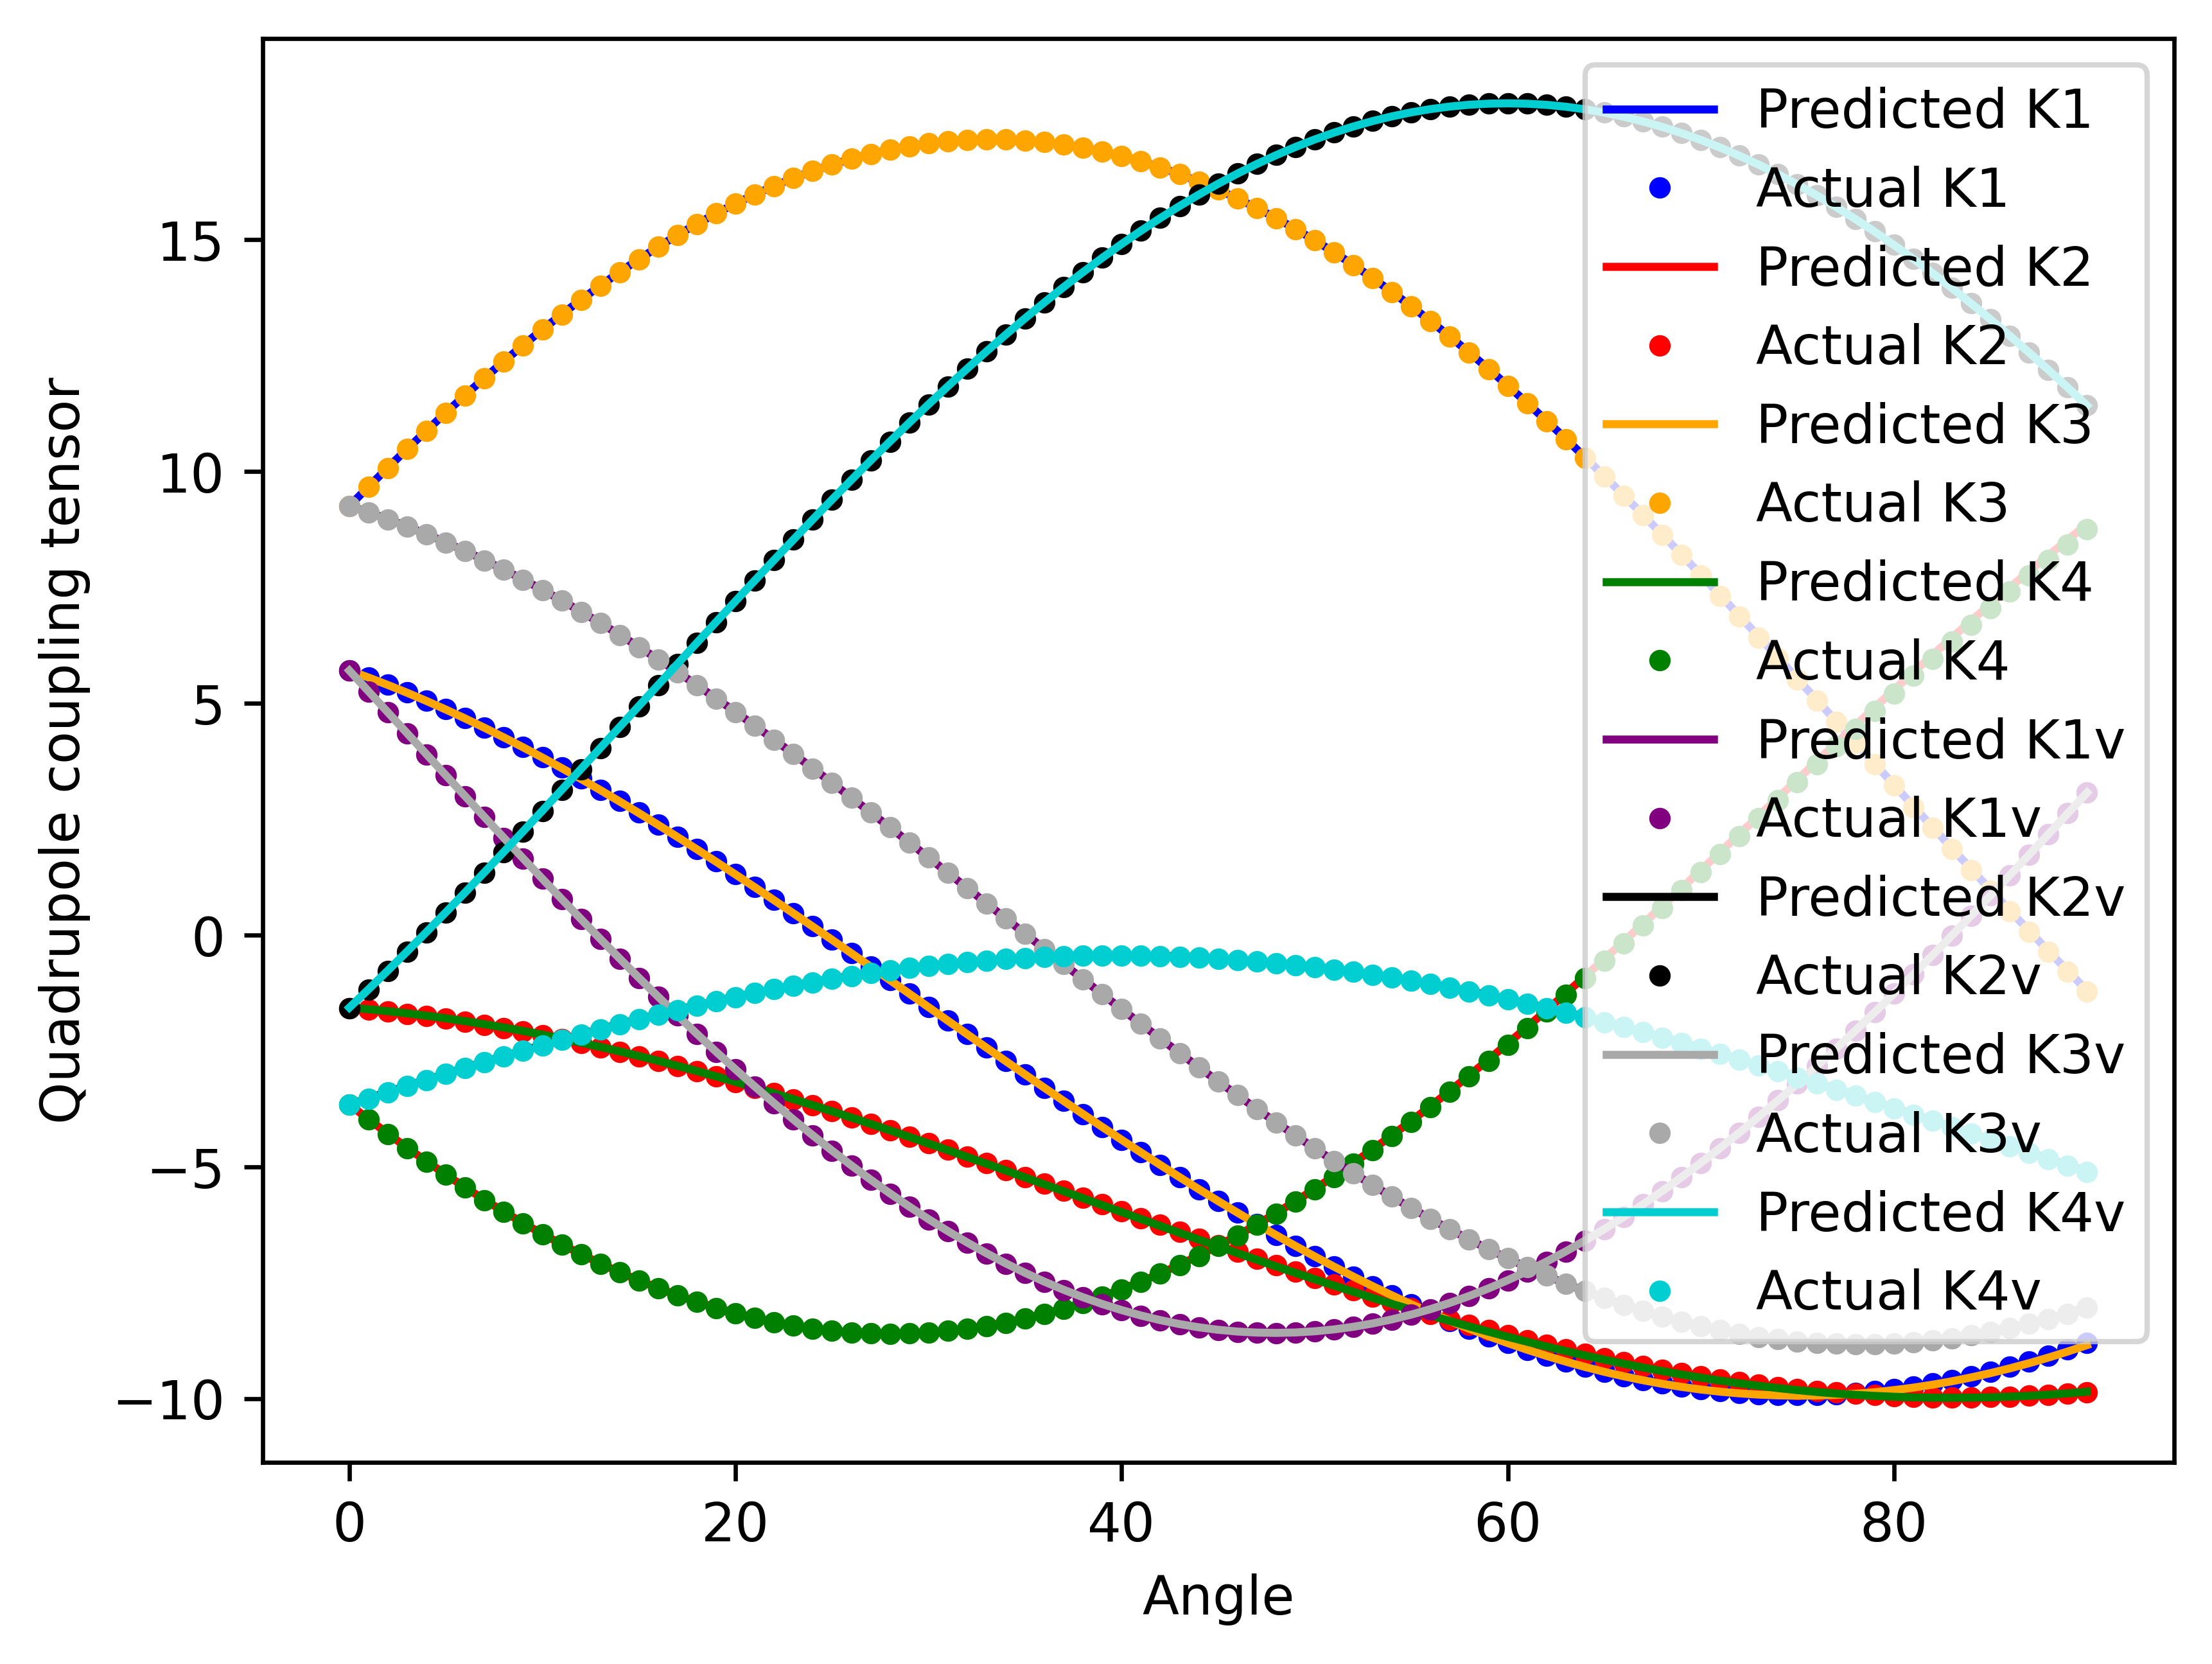

{'k1': -7.9849138259887695, 'k2': 12.997283935546875, 'k3': -5.030964374542236, 'k4': -11.002641677856445, 'k5': 0.0, 'k6': 0.0, 't1': 57.659366607666016, 'p1': 145.6004180908203, 't2': 95.39595031738281, 'p2': 59.51211929321289}


In [23]:
# 最適化後のパラメータを取得し、Tensorに変換
k1 = torch.tensor(global_best_params['k1'], dtype=torch.float32)
k2 = torch.tensor(global_best_params['k2'], dtype=torch.float32)
k3 = torch.tensor(global_best_params['k3'], dtype=torch.float32)
k4 = torch.tensor(global_best_params['k4'], dtype=torch.float32)
k5 = torch.tensor(global_best_params['k5'], dtype=torch.float32)
k6 = torch.tensor(global_best_params['k6'], dtype=torch.float32)
t1 = torch.tensor(global_best_params['t1'], dtype=torch.float32)
p1 = torch.tensor(global_best_params['p1'], dtype=torch.float32)
t2 = torch.tensor(global_best_params['t2'], dtype=torch.float32)
p2 = torch.tensor(global_best_params['p2'], dtype=torch.float32)

# パラメータリストを作成
params = [k1, k2, k3, k4, k5, k6, t1, p1, t2, p2]

outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6, x7, x8]]

y_p1 = outputs[0]['shift1'][0]
y_p2 = outputs[1]['shift1'][1]
y_p3 = outputs[2]['shift1'][2]
y_p4 = outputs[3]['shift1'][3]
y_p5 = outputs[4]['shift2'][0]
y_p6 = outputs[5]['shift2'][1]
y_p7 = outputs[6]['shift2'][2]
y_p8 = outputs[7]['shift2'][3]

# 結果の可視化
fig = plt.figure(dpi=600)

plt.plot(x1.detach().numpy(), y_p1.detach().numpy(), label="Predicted K1", color = "blue") 
plt.plot(x1.detach().numpy(), y1.numpy(), '.', label="Actual K1", color = "blue")

plt.plot(x2.detach().numpy(), y_p2.detach().numpy(), label="Predicted K2", color = "red") 
plt.plot(x2.detach().numpy(), y2.numpy(), '.', label="Actual K2", color = "red")

plt.plot(x3.detach().numpy(), y_p3.detach().numpy(), label="Predicted K3", color = "orange") 
plt.plot(x3.detach().numpy(), y3.numpy(), '.', label="Actual K3", color = "orange")

plt.plot(x4.detach().numpy(), y_p4.detach().numpy(), label="Predicted K4", color = "green") 
plt.plot(x4.detach().numpy(), y4.numpy(), '.', label="Actual K4", color = "green")

plt.plot(x5.detach().numpy(), y_p5.detach().numpy(), label="Predicted K1v", color = "purple") 
plt.plot(x5.detach().numpy(), y5.numpy(), '.', label="Actual K1v", color = "purple")

plt.plot(x6.detach().numpy(), y_p6.detach().numpy(), label="Predicted K2v", color = "black") 
plt.plot(x6.detach().numpy(), y6.numpy(), '.', label="Actual K2v", color = "black")

plt.plot(x7.detach().numpy(), y_p7.detach().numpy(), label="Predicted K3v", color = "darkgrey") 
plt.plot(x7.detach().numpy(), y7.numpy(), '.', label="Actual K3v", color = "darkgrey")

plt.plot(x8.detach().numpy(), y_p8.detach().numpy(), label="Predicted K4v", color = "darkturquoise") 
plt.plot(x8.detach().numpy(), y8.numpy(), '.', label="Actual K4v", color = "darkturquoise")

plt.xlabel("Angle")
plt.ylabel("Quadrupole coupling tensor")
plt.legend()
plt.show()

# 最適化後のパラメータを表示
print(global_best_params)